<a href="https://colab.research.google.com/github/binit-13/Machine-Learning-Notes/blob/main/Simple_ANN_Structure_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Network

Part 1:

- Neural Network
- Gradient Descent
- Toy Dataset
- SGD, GD, Mini-batch SGD

Part 2:

- Computing Analytical Gradient with Backpropagation
- Toy Dataset
- SGD
- Making it work with batches

Part 3:

- Weight initialization
- Bias weight matrix
- More loss/activation functions


Loss_Function (binary_crossentropy):
==> $ \frac{-1}{n }[\sum_{i=1} y_ilog(\hat y_i) + (1-y_i)log(1-\hat y_i) ]$

In [2]:
import numpy as np
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt

In [3]:
X,y = make_classification(n_samples=50,
                          n_features=2,
                          n_informative=1,
                          n_redundant=0,
                          n_classes=2,
                          n_clusters_per_class=1,
                          random_state=12)

In [4]:
X.shape

(50, 2)

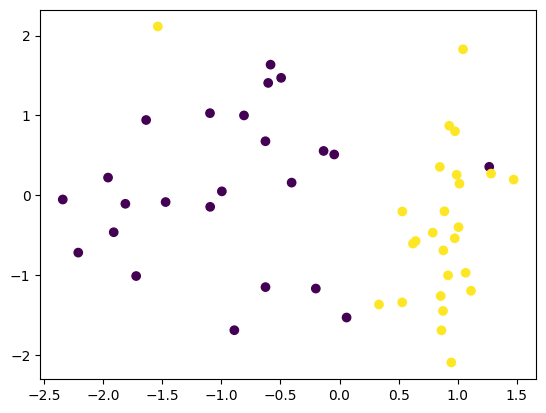

In [4]:
plt.scatter(X[:,0],X[:,1],c=y)

In [322]:
class Neural_Network:

  def __init__(self,epochs, lr, layer, X, input_neuron):
    self.lr = lr
    self.epochs = epochs
    self.layer = layer
    self.counter = 0
    np.random.seed(3)

    self.dict_weight = dict()
    self.dict_bias = dict()
    self.input_dim = X.shape[1]
    self.input_neuron = input_neuron

    self.dict_weight['layer:0'] = np.random.randn(self.input_dim, self.input_neuron) ## input layer being initialized
    self.dict_bias['layer:0'] = np.ones(self.input_neuron)

  def activation(self, X, method = ['sigmoid','relu','linear', 'sigmoid_der','relu_der']):
    if method == 'sigmoid':
      return 1 / (1 + np.exp(-X))

    if method == 'relu':
      return np.where(X > 0, X, 0)

    if method == 'linear':
      return X

    if method == 'sigmoid_der':
      return X * (1-X)

    if method == 'relu_der':
      return np.where(X > 0,1,0)

  def add(self, neuron):

    self.counter +=1
    if self.counter == 1:
      self.dict_weight[f'layer:{self.counter}'] = np.random.randn(neuron,2)
      self.dict_bias[f'layer:{self.counter}'] = np.ones((1,neuron))
    else:
      self.dict_weight[f'layer:{self.counter}'] = np.random.randn(neuron,2)
      self.dict_bias[f'layer:{self.counter}'] = np.ones((1,neuron))

    return self.dict_weight, self.dict_bias


  def forward_network(self,X):

    self.dict_output = dict()
    if self.counter == 1:
      self.dict_output[f'layer:0'] = np.dot(X,self.dict_weight['layer:0'])+self.dict_bias['layer:0']
      self.dict_output[f'layer:0'] = self.activation(self.dict_output[f'layer:0'], method='sigmoid')
      self.dict_output[f'layer:1'] = np.dot(self.dict_output['layer:0'],self.dict_weight['layer:1'].T)
      self.dict_output[f'layer:1'] = self.activation(self.dict_output[f'layer:1'], method='sigmoid')

      return self.dict_output['layer:1']
    else:
      self.dict_output[f'layer:0'] = self.activation(np.dot(X,self.dict_weight['layer:0'])+self.dict_bias['layer:0'],'relu')
      self.dict_output[f'layer:1'] = self.activation(np.dot(self.dict_output['layer:0'],self.dict_weight['layer:1'].T),'relu')
      self.dict_output[f'layer:2'] = self.activation(np.dot(self.dict_output['layer:1'],self.dict_weight['layer:2'].T),'sigmoid')

      return self.dict_output['layer:2'].shape # shape --> (50,1)


  def back_propogation(self,X,y):

    loss = -y * np.log(self.dict_output['layer:1'].reshape(-1)) - (1 - y) * np.log(1 - self.dict_output['layer:1'].reshape(-1)) ## ()
    ## derivative of this w.r.t to weight is:  ---> predicted y - y or -(y-yhat)*Output
    ## derivative of loss w.r.t to bias is : ----> -(y-yhat) or yhat-y


    delta_output = self.dict_output['layer:1']-y ##(50,1)
    delta_weights_output = np.dot(self.dict_output['layer:0'].T, delta_output)
    delta_bias_output = np.sum(delta_output, axis=0)

    #print(delta_weights_output.shape, delta_bias_output.shape)

    # Backpropagation for the hidden layer
    ## derivative of loss w.r.t to weight of hidden layer ---> (yhat-y)*weight*output(1-output)*Input
    delta_layer0 = self.activation(np.dot(delta_output, self.dict_weight['layer:1']), method='relu_der')
    delta_weights_hidden = np.dot(X.T, delta_layer0)
    delta_bias_hidden = np.sum(delta_layer0, axis=0)

    #print(delta_weights_hidden.shape, delta_bias_hidden.shape)

    # Update weights and biases

    self.dict_weight['layer:0'] -= self.lr * delta_weights_hidden
    self.dict_bias['layer:0'] -= self.lr * delta_bias_hidden

    self.dict_weight['layer:1'] -= self.lr * delta_weights_output.T
    self.dict_bias['layer:1'] -= self.lr * delta_bias_output

    #print(self.dict_weight['layer:1'], loss.shape)

    return loss

  def compile(self,X,y):
    loss = []
    for epoch in range(self.epochs):
      total_loss = 0
      for i in range(len(X)):
        x = X[i].reshape(1, -1)
        target = y[i].reshape(1, -1)
        output = self.forward_network(x)
        total_loss = self.back_propogation(x, target)
        loss.append(total_loss)
      print('Epoch - ',epoch+1,'Loss - ',np.mean(loss))

  def predict(self, X):
    pred = []
    for i in range(len(X)):
      x = X[i].reshape(1,-1)
      output = self.forward_network(x)
      pred.append(output)

    return np.array(pred)

  def summary(self):
    print('0 layer: params', np.prod(self.dict_weight['layer:0'].shape) + np.prod(self.dict_bias['layer:0'].shape))
    print('-'*30)
    for i in reversed(range(self.counter+1)):
      if i == 0:
        break
      else:
        print(f'{i} layer: params:', np.prod(self.dict_weight[f'layer:{i}'].shape) + np.prod(self.dict_bias[f'layer:{i}'].shape))
        print('-'*30)


In [323]:
model = Neural_Network(epochs=7,lr=0.05,layer=2,X=X, input_neuron=2)

In [324]:
model.add(1)
#model.add(1)

({'layer:0': array([[ 1.78862847,  0.43650985],
         [ 0.09649747, -1.8634927 ]]),
  'layer:1': array([[-0.2773882 , -0.35475898]])},
 {'layer:0': array([1., 1.]), 'layer:1': array([[1.]])})

In [325]:
model.summary()

0 layer: params 6
------------------------------
1 layer: params: 3
------------------------------


In [326]:
model.compile(X,y)

Epoch -  1 Loss -  0.7235172613433108
Epoch -  2 Loss -  0.6809083977388724
Epoch -  3 Loss -  0.6447036025252005
Epoch -  4 Loss -  0.6171441749787099
Epoch -  5 Loss -  0.5965074218853315
Epoch -  6 Loss -  0.5807005295315959
Epoch -  7 Loss -  0.5683210488119157


In [327]:
model.predict(X)

array([[[0.46997311]],

       [[0.69412821]],

       [[0.80438227]],

       [[0.74480681]],

       [[0.71148865]],

       [[0.76478896]],

       [[0.25962162]],

       [[0.69288001]],

       [[0.25816649]],

       [[0.62189315]],

       [[0.49630173]],

       [[0.49839775]],

       [[0.8159952 ]],

       [[0.72454518]],

       [[0.32394703]],

       [[0.52335105]],

       [[0.82353824]],

       [[0.74297271]],

       [[0.53929537]],

       [[0.48368392]],

       [[0.68895062]],

       [[0.64359041]],

       [[0.43883477]],

       [[0.51668719]],

       [[0.8173119 ]],

       [[0.41703231]],

       [[0.28447464]],

       [[0.75169734]],

       [[0.49960968]],

       [[0.70852857]],

       [[0.27498443]],

       [[0.76465112]],

       [[0.25761267]],

       [[0.48591769]],

       [[0.46515295]],

       [[0.49986813]],

       [[0.49873951]],

       [[0.25724356]],

       [[0.68788232]],

       [[0.50040987]],

       [[0.79283502]],

       [[0.25959

In [317]:
y

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0])